## **Modules**

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import lightgbm as lgb
import matplotlib.pyplot as plt

from sklearn.metrics import *
from sklearn.preprocessing import Binarizer
from sklearn.calibration import calibration_curve
from sklearn.model_selection import train_test_split

## **Data**

**Import the normalized data**

In [2]:
file_path = "normalized_data.csv"
df = pd.read_csv(file_path)
df

,Unnamed: 0,open,high,low,close,volume,quote_asset_volume,number_of_trades,taker_buy_base_asset_volume,taker_buy_quote_asset_volume,...,low_MeanDev48_over_StdDev48,close_MeanDev48_over_StdDev48,open_MeanDev96_over_StdDev96,high_MeanDev96_over_StdDev96,low_MeanDev96_over_StdDev96,close_MeanDev96_over_StdDev96,open_MeanDev192_over_StdDev192,high_MeanDev192_over_StdDev192,low_MeanDev192_over_StdDev192,close_MeanDev192_over_StdDev192
0,359,0.018495,0.009785,0.018383,0.004281,1180.825933,-0.241505,11017.0,612.021981,0.000000,...,0.370477,0.661152,-1.950690,-1.881119,-1.871933,-1.950690,0.593925,0.969559,-0.596205,0.593925
1,360,0.004956,-0.008991,-0.004450,-0.003945,693.787209,-0.732426,8059.0,343.998248,0.000000,...,0.480687,0.630321,-1.811761,-1.745879,-1.770050,-1.811761,0.371924,0.791939,-1.087814,0.371924
2,361,-0.003946,0.004507,-0.000473,-0.003816,639.808801,-0.784803,6949.0,297.590606,0.000000,...,0.389880,0.548217,-1.678097,-1.709976,-1.709619,-1.678097,-0.010608,0.631068,-1.541996,-0.010608
3,362,-0.003369,-0.005212,0.002062,0.006863,463.446578,-0.958557,5328.0,232.254343,0.000000,...,0.350033,0.460780,-1.660865,-1.701925,-1.692418,-1.660865,-0.052136,0.782304,-1.830356,-0.052136
4,363,0.006419,0.004713,0.002860,-0.002752,634.129456,-0.787283,7406.0,318.341325,0.000000,...,0.247121,0.354412,-1.587490,-1.630426,-1.655253,-1.587490,-0.142859,0.554341,-1.989684,-0.142859
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38443,38802,-0.003626,-0.002886,-0.009204,-0.008336,2613.774410,-0.703874,42193.0,1245.791750,-0.887751,...,0.894451,1.038517,-0.844173,-0.114303,-1.152432,-0.844173,-1.239710,-1.730291,-2.099255,-1.239710
38444,38803,-0.008337,-0.009908,-0.006327,-0.006609,4195.854000,-0.346556,58827.0,1911.811000,-0.560005,...,0.435777,0.910978,-0.640086,-0.109049,-1.067451,-0.640086,-2.261169,-2.252223,-2.587937,-2.261169
38445,38804,-0.006609,-0.000843,-0.001635,-0.008575,3271.915890,-0.552267,53095.0,1526.045120,-0.747297,...,0.309717,0.506155,-0.569034,0.065389,-0.977107,-0.569034,-2.692674,-2.448695,-2.436019,-2.692674
38446,38805,-0.008575,-0.009336,-0.002849,0.002702,3588.324010,-0.482464,53154.0,1650.636910,-0.678239,...,0.400968,0.594548,-0.490384,0.124920,-0.895412,-0.490384,-2.263128,-2.371402,-2.230504,-2.263128


**Define the periods of time that the features have in the data**

For example, the features contain SMA2 which is the smoothed moving average during 2 days, so a period of time that must be in the periods list is 2.

In [3]:
periods = [2,4,8,12,24,48,96,192]

**Label value counts**

In [4]:
df["label"].value_counts()

True     19580
False    18868
Name: label, dtype: int64

### **Data Preprocessing**

**Drop useless column**

In [5]:
df.drop(columns=["Unnamed: 0"], inplace=True)

**Drop nan if exist**

In [6]:
# Print all the amount of nan values
df.isna().sum().sum()

0

Or forward fill before drop, this forward filling can avoid data leakeage!

In [7]:
forward_fill = False

if forward_fill:
    df.ffill(inplace=True)
else:
    df.dropna(inplace=True)

Reset index

In [8]:
df.reset_index(drop=True, inplace=True)

**Create train set, validation set and test set**

In [9]:
X_df = df.drop(columns=["label"])
y_df = df["label"]

In [10]:
X_train_df, X_test_df, y_train_df, y_test_df = train_test_split(X_df, y_df, test_size=0.3, shuffle=False)
X_val_df, X_test_df, y_val_df, y_test_df = train_test_split(X_test_df, y_test_df, test_size=0.5, shuffle=False)

In [11]:
X_train = X_train_df
X_val = X_val_df
X_test = X_test_df

y_train = y_train_df
y_val = y_val_df
y_test = y_test_df

## **Model and training**

**Training**

In [12]:
depth = 4
rate = 0.2
lr = 0.002

train_data = lgb.Dataset(X_train, y_train)
valid_data = lgb.Dataset(X_val, y_val, reference=train_data)

params = {'objective': 'binary' ,
                      'metric': ['cross_entropy'],
                      'boosting':'gbdt', 
                      'num_boost_round':4096,
                      'early_stopping_round':32,
                      'learning_rate': lr,
                      'max_depth': depth,
                      'num_leaves': 2**depth,
                      'feature_fraction': rate,
                      'verbosity': 1}

print(params)

model = lgb.train(params, train_data,                     
                  valid_sets=[train_data, valid_data],
                  valid_names=['train', 'valid'])

{'objective': 'binary', 'metric': ['cross_entropy'], 'boosting': 'gbdt', 'num_boost_round': 4096, 'early_stopping_round': 32, 'learning_rate': 0.002, 'max_depth': 4, 'num_leaves': 16, 'feature_fraction': 0.2, 'verbosity': 1}


/home/hoangvictor/Installations/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 13810, number of negative: 13103
[LightGBM] [Info] [cross_entropy:Init]: (metric) labels passed interval [0, 1] check
[LightGBM] [Info] [cross_entropy:Init]: sum-of-weights = 26913.000000
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.060396 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 377284
[LightGBM] [Info] Number of data points in the train set: 26913, number of used features: 1487
[LightGBM] [Info] [cross_entropy:Init]: (metric) labels passed interval [0, 1] check
[LightGBM] [Info] [cross_entropy:Init]: sum-of-weights = 5767.000000
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.513135 -> initscore=0.052552
[LightGBM] [Info] Start training from score 0.052552
[1]	train's cross_entropy: 0.692754	valid's cross_entropy: 0.693103
Training until validation scores don't improve for 32 rounds
[2]	train's cross_entropy: 0.692705	valid's cross_entropy: 0.69

[123]	train's cross_entropy: 0.687609	valid's cross_entropy: 0.691443
[124]	train's cross_entropy: 0.68757	valid's cross_entropy: 0.691425
[125]	train's cross_entropy: 0.687534	valid's cross_entropy: 0.691415
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[126]	train's cross_entropy: 0.687497	valid's cross_entropy: 0.691398
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[127]	train's cross_entropy: 0.687466	valid's cross_entropy: 0.691394
[128]	train's cross_entropy: 0.687427	valid's cross_entropy: 0.691384
[129]	train's cross_entropy: 0.687391	valid's cross_entropy: 0.691381
[130]	train's cross_entropy: 0.687353	valid's cross_entropy: 0.691378
[131]	train's cross_entropy: 0.687317	valid's cross_entropy: 0.691365
[132]	train's cross_entropy: 0.687278	valid's cross_entropy: 0.691352
[133]	train's cross_entropy: 0.687241	valid's cross_entropy: 0.691339
[134]	train's cross_entropy: 0.687201	valid's cross_entropy: 0.691324
[135]	train

[241]	train's cross_entropy: 0.683739	valid's cross_entropy: 0.690418
[242]	train's cross_entropy: 0.683711	valid's cross_entropy: 0.690411
[243]	train's cross_entropy: 0.68368	valid's cross_entropy: 0.690401
[244]	train's cross_entropy: 0.683648	valid's cross_entropy: 0.690396
[245]	train's cross_entropy: 0.683615	valid's cross_entropy: 0.690388
[246]	train's cross_entropy: 0.683586	valid's cross_entropy: 0.690371
[247]	train's cross_entropy: 0.683556	valid's cross_entropy: 0.690358
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[248]	train's cross_entropy: 0.683527	valid's cross_entropy: 0.690344
[249]	train's cross_entropy: 0.683499	valid's cross_entropy: 0.69035
[250]	train's cross_entropy: 0.683469	valid's cross_entropy: 0.690353
[251]	train's cross_entropy: 0.683441	valid's cross_entropy: 0.690349
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[252]	train's cross_entropy: 0.683414	valid's cross_entropy: 0.690342
[253]	train'

[380]	train's cross_entropy: 0.680077	valid's cross_entropy: 0.689757
[381]	train's cross_entropy: 0.68005	valid's cross_entropy: 0.689753
[382]	train's cross_entropy: 0.680027	valid's cross_entropy: 0.68975
[383]	train's cross_entropy: 0.680004	valid's cross_entropy: 0.689747
[384]	train's cross_entropy: 0.679981	valid's cross_entropy: 0.689742
[385]	train's cross_entropy: 0.679958	valid's cross_entropy: 0.689744
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[386]	train's cross_entropy: 0.679937	valid's cross_entropy: 0.689735
[387]	train's cross_entropy: 0.67991	valid's cross_entropy: 0.689734
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[388]	train's cross_entropy: 0.679892	valid's cross_entropy: 0.689731
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[389]	train's cross_entropy: 0.679874	valid's cross_entropy: 0.689729
[390]	train's cross_entropy: 0.679847	valid's cross_entropy: 0.689728
[391]	tr

[505]	train's cross_entropy: 0.677348	valid's cross_entropy: 0.689387
[506]	train's cross_entropy: 0.677327	valid's cross_entropy: 0.689384
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[507]	train's cross_entropy: 0.677309	valid's cross_entropy: 0.68938
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[508]	train's cross_entropy: 0.677293	valid's cross_entropy: 0.689378
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[509]	train's cross_entropy: 0.677276	valid's cross_entropy: 0.689375
[510]	train's cross_entropy: 0.677256	valid's cross_entropy: 0.68937
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[511]	train's cross_entropy: 0.677238	valid's cross_entropy: 0.689366
[512]	train's cross_entropy: 0.677218	valid's cross_entropy: 0.689364
[513]	train's cross_entropy: 0.677197	valid's cross_entropy: 0.689365
[LightGBM] [Warning] No further splits with positive gain, best gain: -i

[601]	train's cross_entropy: 0.675494	valid's cross_entropy: 0.689203
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[602]	train's cross_entropy: 0.675479	valid's cross_entropy: 0.6892
[603]	train's cross_entropy: 0.675459	valid's cross_entropy: 0.689201
[604]	train's cross_entropy: 0.67544	valid's cross_entropy: 0.689202
[605]	train's cross_entropy: 0.675421	valid's cross_entropy: 0.689199
[606]	train's cross_entropy: 0.6754	valid's cross_entropy: 0.689204
[607]	train's cross_entropy: 0.675382	valid's cross_entropy: 0.689206
[608]	train's cross_entropy: 0.675362	valid's cross_entropy: 0.689205
[609]	train's cross_entropy: 0.675342	valid's cross_entropy: 0.689206
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[610]	train's cross_entropy: 0.675325	valid's cross_entropy: 0.689201
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[611]	train's cross_entropy: 0.675307	valid's cross_entropy: 0.689205
[612]	trai

[704]	train's cross_entropy: 0.673643	valid's cross_entropy: 0.68905
[705]	train's cross_entropy: 0.673624	valid's cross_entropy: 0.689047
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[706]	train's cross_entropy: 0.673607	valid's cross_entropy: 0.689043
[707]	train's cross_entropy: 0.67359	valid's cross_entropy: 0.689032
[708]	train's cross_entropy: 0.673572	valid's cross_entropy: 0.689033
[709]	train's cross_entropy: 0.673554	valid's cross_entropy: 0.689036
[710]	train's cross_entropy: 0.673536	valid's cross_entropy: 0.689032
[711]	train's cross_entropy: 0.673518	valid's cross_entropy: 0.689026
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[712]	train's cross_entropy: 0.673502	valid's cross_entropy: 0.689027
[713]	train's cross_entropy: 0.673484	valid's cross_entropy: 0.689024
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[714]	train's cross_entropy: 0.673467	valid's cross_entropy: 0.689028
[715]	t

[807]	train's cross_entropy: 0.671894	valid's cross_entropy: 0.688911
[808]	train's cross_entropy: 0.671876	valid's cross_entropy: 0.688909
[809]	train's cross_entropy: 0.671858	valid's cross_entropy: 0.688911
[810]	train's cross_entropy: 0.671842	valid's cross_entropy: 0.68891
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[811]	train's cross_entropy: 0.671825	valid's cross_entropy: 0.688911
[812]	train's cross_entropy: 0.671807	valid's cross_entropy: 0.68891
[813]	train's cross_entropy: 0.671789	valid's cross_entropy: 0.688906
[814]	train's cross_entropy: 0.67177	valid's cross_entropy: 0.688886
[815]	train's cross_entropy: 0.671752	valid's cross_entropy: 0.688886
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[816]	train's cross_entropy: 0.67174	valid's cross_entropy: 0.688885
[817]	train's cross_entropy: 0.671723	valid's cross_entropy: 0.688885
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[818]	tra

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[915]	train's cross_entropy: 0.670155	valid's cross_entropy: 0.688766
[916]	train's cross_entropy: 0.670139	valid's cross_entropy: 0.688763
[917]	train's cross_entropy: 0.670122	valid's cross_entropy: 0.688759
[918]	train's cross_entropy: 0.670107	valid's cross_entropy: 0.688759
[919]	train's cross_entropy: 0.670092	valid's cross_entropy: 0.68876
[920]	train's cross_entropy: 0.670076	valid's cross_entropy: 0.68876
[921]	train's cross_entropy: 0.670059	valid's cross_entropy: 0.688758
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[922]	train's cross_entropy: 0.670044	valid's cross_entropy: 0.688761
[923]	train's cross_entropy: 0.670027	valid's cross_entropy: 0.688758
[924]	train's cross_entropy: 0.670012	valid's cross_entropy: 0.688763
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[925]	train's cross_entropy: 0.669996	valid's cross_entropy: 0.688766
[926]	t

[1024]	train's cross_entropy: 0.668454	valid's cross_entropy: 0.688678
[1025]	train's cross_entropy: 0.668438	valid's cross_entropy: 0.688682
[1026]	train's cross_entropy: 0.668422	valid's cross_entropy: 0.688683
[1027]	train's cross_entropy: 0.668406	valid's cross_entropy: 0.688681
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1028]	train's cross_entropy: 0.668391	valid's cross_entropy: 0.688676
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1029]	train's cross_entropy: 0.668378	valid's cross_entropy: 0.688684
[1030]	train's cross_entropy: 0.668362	valid's cross_entropy: 0.688685
[1031]	train's cross_entropy: 0.668346	valid's cross_entropy: 0.688682
[1032]	train's cross_entropy: 0.66833	valid's cross_entropy: 0.688674
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1033]	train's cross_entropy: 0.668316	valid's cross_entropy: 0.688672
[LightGBM] [Warning] No further splits with positive gain, best ga

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1132]	train's cross_entropy: 0.666822	valid's cross_entropy: 0.688529
[1133]	train's cross_entropy: 0.666805	valid's cross_entropy: 0.68853
[1134]	train's cross_entropy: 0.66679	valid's cross_entropy: 0.688526
[1135]	train's cross_entropy: 0.666774	valid's cross_entropy: 0.688525
[1136]	train's cross_entropy: 0.666759	valid's cross_entropy: 0.688523
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1137]	train's cross_entropy: 0.666745	valid's cross_entropy: 0.688523
[1138]	train's cross_entropy: 0.666729	valid's cross_entropy: 0.688523
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1139]	train's cross_entropy: 0.666715	valid's cross_entropy: 0.688524
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1140]	train's cross_entropy: 0.666704	valid's cross_entropy: 0.688526
[LightGBM] [Warning] No further splits with positive gain, best

[1243]	train's cross_entropy: 0.665242	valid's cross_entropy: 0.68846
[1244]	train's cross_entropy: 0.665227	valid's cross_entropy: 0.688459
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1245]	train's cross_entropy: 0.665214	valid's cross_entropy: 0.688458
[1246]	train's cross_entropy: 0.665198	valid's cross_entropy: 0.688456
[1247]	train's cross_entropy: 0.665183	valid's cross_entropy: 0.688459
[1248]	train's cross_entropy: 0.665167	valid's cross_entropy: 0.688451
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1249]	train's cross_entropy: 0.665156	valid's cross_entropy: 0.688449
[1250]	train's cross_entropy: 0.665141	valid's cross_entropy: 0.688452
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1251]	train's cross_entropy: 0.665128	valid's cross_entropy: 0.68845
[1252]	train's cross_entropy: 0.665112	valid's cross_entropy: 0.688446
[1253]	train's cross_entropy: 0.665096	valid's cross_entropy: 0.688

[1355]	train's cross_entropy: 0.663677	valid's cross_entropy: 0.688359
[1356]	train's cross_entropy: 0.663662	valid's cross_entropy: 0.688356
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1357]	train's cross_entropy: 0.663649	valid's cross_entropy: 0.688354
[1358]	train's cross_entropy: 0.663635	valid's cross_entropy: 0.688351
[1359]	train's cross_entropy: 0.663621	valid's cross_entropy: 0.688349
[1360]	train's cross_entropy: 0.663605	valid's cross_entropy: 0.688345
[1361]	train's cross_entropy: 0.663592	valid's cross_entropy: 0.688343
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1362]	train's cross_entropy: 0.66358	valid's cross_entropy: 0.688344
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1363]	train's cross_entropy: 0.663567	valid's cross_entropy: 0.688346
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1364]	train's cross_entropy: 0.663554	valid's cross_entropy: 

**Evaluation**

In [13]:
print("Test set:")
predicted_y = model.predict(X_test).reshape(-1,1)
target_y = y_test.to_numpy().reshape(-1,1)

transformed_predicted_y = Binarizer(threshold=np.median(model.predict(X_val))).fit_transform(predicted_y)

print(classification_report(target_y, transformed_predicted_y))
print("Confusion matrix:\n", confusion_matrix(target_y, transformed_predicted_y))

acc = accuracy_score(target_y, transformed_predicted_y)
print("Accuracy:", acc)

Test set:
              precision    recall  f1-score   support

       False       0.56      0.57      0.56      2922
        True       0.55      0.54      0.54      2846

    accuracy                           0.55      5768
   macro avg       0.55      0.55      0.55      5768
weighted avg       0.55      0.55      0.55      5768

Confusion matrix:
 [[1655 1267]
 [1316 1530]]
Accuracy: 0.5521844660194175


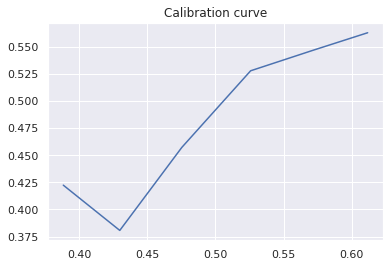

In [14]:
sns.set()
prob_true, prob_pred = calibration_curve(y_test, model.predict(X_test), n_bins=20)
plt.plot(prob_pred, prob_true)
plt.title("Calibration curve")
plt.show()

In [15]:
print("Validation set:")
predicted_y = model.predict(X_val).reshape(-1,1)
target_y = y_val.to_numpy().reshape(-1,1)

transformed_predicted_y = Binarizer(threshold=0.5).fit_transform(predicted_y)

print(classification_report(target_y, transformed_predicted_y))
print("Confusion matrix:\n", confusion_matrix(target_y, transformed_predicted_y))

acc = accuracy_score(target_y, transformed_predicted_y)
print("Accuracy:", acc)

Validation set:
              precision    recall  f1-score   support

       False       0.54      0.43      0.48      2843
        True       0.54      0.64      0.58      2924

    accuracy                           0.54      5767
   macro avg       0.54      0.53      0.53      5767
weighted avg       0.54      0.54      0.53      5767

Confusion matrix:
 [[1227 1616]
 [1063 1861]]
Accuracy: 0.5354603780128316


In [16]:
print("Train set:")
predicted_y = model.predict(X_train).reshape(-1,1)
target_y = y_train.to_numpy().reshape(-1,1)

transformed_predicted_y = Binarizer(threshold=0.5).fit_transform(predicted_y)

print(classification_report(target_y, transformed_predicted_y))
print("Confusion matrix:\n", confusion_matrix(target_y, transformed_predicted_y))

acc = accuracy_score(target_y, transformed_predicted_y)
print("Accuracy:", acc)

Train set:
              precision    recall  f1-score   support

       False       0.61      0.53      0.57     13103
        True       0.61      0.69      0.64     13810

    accuracy                           0.61     26913
   macro avg       0.61      0.61      0.61     26913
weighted avg       0.61      0.61      0.61     26913

Confusion matrix:
 [[6926 6177]
 [4342 9468]]
Accuracy: 0.6091479953925613


**Features importance**

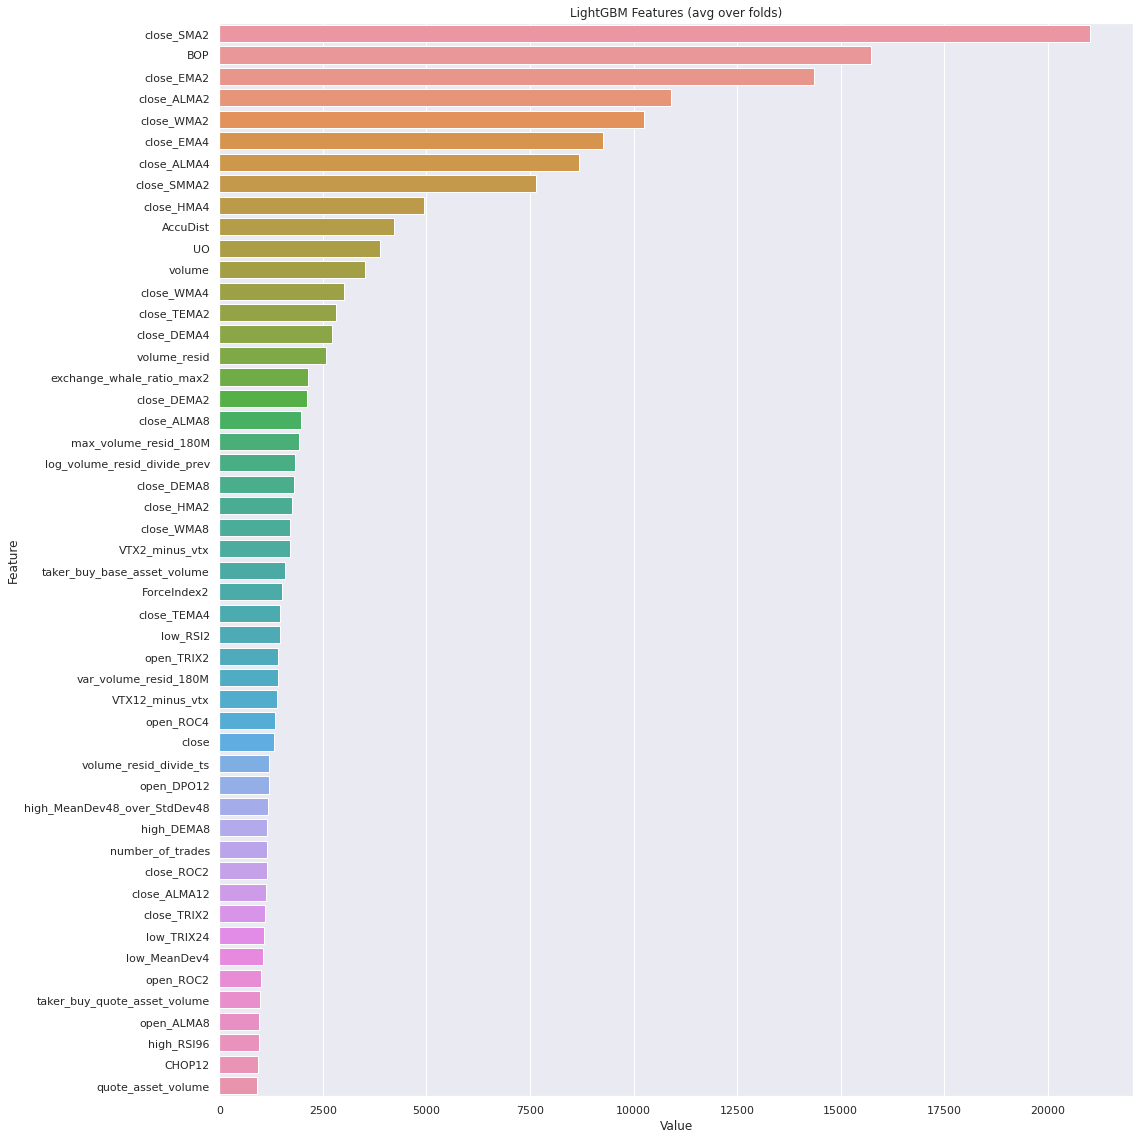

In [17]:
def plotImp(model, X , num = 50, fig_size = (16, 16)):
    feature_imp = pd.DataFrame({'Value':model.feature_importance(importance_type='gain'),'Feature':X.columns})
    plt.figure(figsize=fig_size)
    sns.set(font_scale = 1)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", 
                                                        ascending=False)[0:num])
    plt.title('LightGBM Features (avg over folds)')
    plt.tight_layout()
    plt.show()
    
plotImp(model, X_test)